In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as onp

import jax.numpy as jnp

from jax import random

import matplotlib.pyplot as plt

from jax.scipy.stats import norm

from numpyro import sample as npy_smpl
import numpyro.infer as npy_inf
import numpyro.distributions as npy_dist

from scipy.stats import gaussian_kde


from jax_sgmc import potential
from jax_sgmc.data.numpy_loader import NumpyDataLoader
from jax_sgmc import alias

# Quickstart

## Data Generation

For demonstration purposes, we look at the simple problem 

```{math}
y^{(i)} \sim \mathcal{N}\left(\sum_{j=1}^d w_jx_j^{(i)}, \sigma^2\right)
```

where $d \ll N$ such that we have a large amount of reference data.

The reference data is generated such that the weights are correlated:

```{math}
u_1, u_2, u_3, u_4 \sim \mathcal{U}\left(-1, 1 \right)
```

and

```{math}
\boldsymbol{x} = \left(\begin{array}{c} u_1 + u_2 \\ u_2 \\ 0.1u_3 -0.5u_4 \\ u_4 \end{array} \right).
```

The correct solution $w$ is drawn randomly from

```{math}
w_j \sim \mathcal{U}\left(-1, 1\right)
```

and the standard deviation of the error is chosen to be

```{math}
\sigma = 0.5.
```

In [ ]:
N = 4 
samples = 1000 # Total samples

key = random.PRNGKey(0)
split1, split2, split3 = random.split(key, 3)

# Correct solution
sigma = 0.5
w = random.uniform(split3, minval=-1, maxval=1, shape=(N, 1))

# Data generation
noise = sigma * random.normal(split2, shape=(samples, 1))
x = random.uniform(split1, minval=-10, maxval=10, shape=(samples, N))
x = jnp.stack([x[:, 0] + x[:, 1], x[:, 1], 0.1 * x[:, 2] - 0.5 * x[:, 3],
               x[:, 3]]).transpose()
y = jnp.matmul(x, w) + noise

## Data Loader

A feature of **JaxSGMC** is that it can store large datasets on the host and
only send chunks of it to jit-compiled functions on the device (GPU)
when they are required.

Therefore, reference data must be stored in a ``DataLoader`` class, which
also takes care of batching and shuffling. 

If the data fits into the host memory and is available as numpy arrays, then the
``NumpyDataLoader`` can be used. It expects a single or multiple arrays where
all observations are concatenated along the first dimension. The arrays are
passed as keyword-arguments and the batches are returned as a flat dictionary
with the corresponding keys.

For our dataset, we stick to the names x and y such that we can later access the
data via ``batch['x']`` and ``batch['y']``:

In [ ]:
data_loader = NumpyDataLoader(x=x, y=y)

Sometimes, a model needs the shape and type of the data to initialize its state.
Therefore, each DataLoader has a method to get an all-zero observation and an
all-zero batch of observations:

In [ ]:
# Print a single observation
print("Single observation:")
print(data_loader.initializer_batch())

# Print a batch of observations, e. g. to initialize the model
print("Batch of two observations:")
print(data_loader.initializer_batch(2))

Note that the returned dictionary has the keys ``x`` and ``y``, just like the
arrays have been passed to the ``NumpyDataLoader``.

## Likelihood and Prior

The model is connected to the solver via the (log-)prior and (log-)likelihood
function. The model for our problem is:

In [ ]:
def model(sample, observations):
    weights = sample["w"]
    predictors = observations["x"]
    return jnp.dot(predictors, weights)

**JaxSGMC** supports samples in the form of pytrees, so no flattering of e.g.
Neural Net parameters is necessary. In our case we can separate the standard
deviation, which is only part of the likelihood, from the weights by using a
dictionary:

In [ ]:
def likelihood(sample, observations):
    sigma = jnp.exp(sample["log_sigma"])
    y = observations["y"]
    y_pred = model(sample, observations)
    return norm.logpdf(y - y_pred, scale=sigma)

def prior(sample):
    return 1 / jnp.exp(sample["log_sigma"])
    

The prior and likelihood are not passed to the solver directly, but 
first transformed into a (stochastic) potential.
This allowed us to formulate the model and so the likelihood with only a single 
observation in mind and let **JaxSGMC** take care of evaluating it for a batch
of observations. As the model is not computationally demanding, we let 
**JaxSGMC** vectorize the evaluation of the likelihood:

In [ ]:
potential_fn = potential.minibatch_potential(prior=prior,
                                             likelihood=likelihood,
                                             strategy="vmap")                                    

For more complex models it is also possible to sequentially evaluate the
likelihood via ``"map"`` or to make use of multiple accelerators via ``"pmap"``.

Note that it is also possible to write the likelihood for a batch of
observations and that **JaxSGMC** also supports stateful models (see 
{doc}`/usage/potential`).

## Solvers in alias.py

Samples can be generated by using one of the ready to use solvers in
**JaxSGMC**, which can be found in ``alias.py``.

First, the solver must be built from the previously generated potential, the
data loader and some static settings.

In [ ]:
sgld = alias.sgld(potential_fn,
                  data_loader,
                  cache_size=512,
                  batch_size=2,
                  burn_in=20000,
                  accepted_samples=1000,
                  rms_prop=True,
                  progress_bar=False)
                  

Afterwards, the solver can be applied to multiple initial samples, which are
passed as positional arguments. Each inital sample is the starting point of a
dedicated Markov chain, allowing straightforward multi-chain SG-MCMC sampling.
Note that the initial sample has the same from as the sample we expect in our
likelihood.
The solver then returns a list of results, one for each initial sample, which
contain solver-specific additional information beside the samples:

In [ ]:
iterations = 50000
init_sample = {"w": jnp.zeros((N, 1)), "log_sigma": jnp.array(1.0)}

# Run the solver
results = sgld(init_sample, iterations=iterations)

# Access the obtained samples from the first Markov chain
results = results[0]["samples"]["variables"]

For a full list of ready to use solvers see {doc}`/api/jax_sgmc.alias`.
Moreover, it is possible to construct custom solvers by the combination of
different modules.

## Comparison with NumPyro

In the following section, we plot the results of the solver and compare it with
a solution returned by [NumPyro](https://github.com/pyro-ppl/numpyro).

### NumPyro Solution

In [10]:
def numpyro_model(y_obs=None):
  sigma = npy_smpl("sigma", npy_dist.Uniform(low=0.0, high=10.0))
  weights = npy_smpl("weights",
                     npy_dist.Uniform(low=-10 * jnp.ones((N, 1)),
                                      high=10 * jnp.ones((N, 1))))

  y_pred = jnp.matmul(x, weights)
  npy_smpl("likelihood", npy_dist.Normal(loc=y_pred, scale=sigma), obs=y_obs)

# Collect 1000 samples

kernel = npy_inf.HMC(numpyro_model)
mcmc = npy_inf.MCMC(kernel, num_warmup=1000, num_samples=1000, progress_bar=False)
mcmc.run(random.PRNGKey(0), y_obs=y)
mcmc.print_summary()

w_npy = mcmc.get_samples()["weights"]


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       sigma      0.50      0.01      0.50      0.48      0.52    959.60      1.00
weights[0,0]      0.09      0.00      0.09      0.09      0.10    514.32      1.00
weights[1,0]     -0.49      0.00     -0.49     -0.50     -0.48   1451.74      1.00
weights[2,0]     -0.18      0.03     -0.18     -0.23     -0.14    198.11      1.00
weights[3,0]     -0.65      0.01     -0.65     -0.67     -0.62    199.27      1.00

Number of divergences: 0


### Comparison

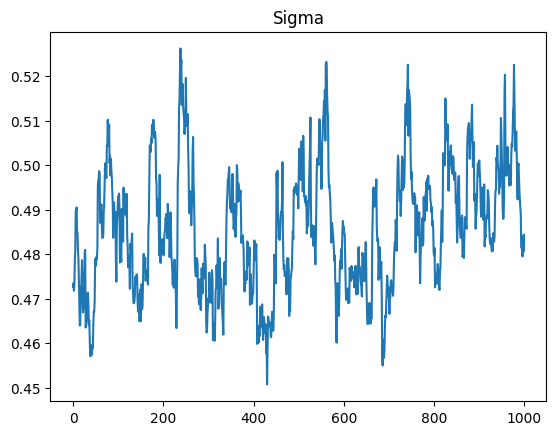

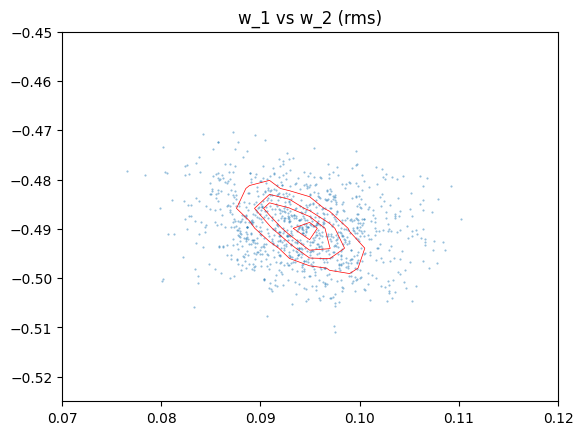

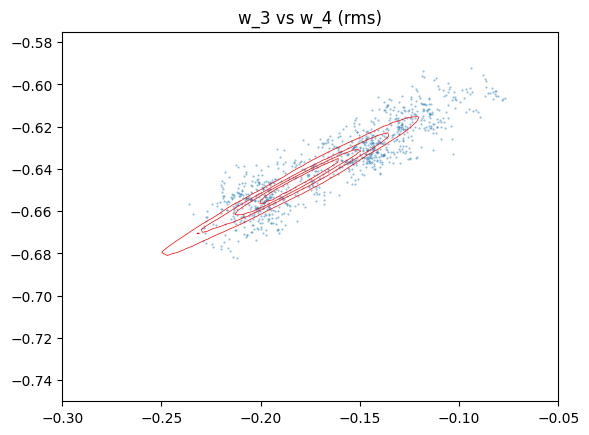

In [11]:
plt.figure()
plt.title("Sigma")

plt.plot(onp.exp(results["log_sigma"]), label="RMSprop")

w_rms = results["w"]

# Contours of NumPyro solution

levels = onp.linspace(0.1, 1.0, 5)

# w1 vs w2
w12 = gaussian_kde(jnp.squeeze(w_npy[:, 0:2].transpose()))
w1d = onp.linspace(0.00, 0.20, 100)
w2d = onp.linspace(-0.70, -0.30, 100)
W1d, W2d = onp.meshgrid(w1d, w2d)
p12d = onp.vstack([W1d.ravel(), W2d.ravel()])
Z12d = onp.reshape(w12(p12d).T, W1d.shape)
Z12d /= Z12d.max()

plt.figure()
plt.title("w_1 vs w_2 (rms)")

plt.xlim([0.07, 0.12])
plt.ylim([-0.525, -0.450])
plt.contour(W1d, W2d, Z12d, levels, colors='red', linewidths=0.5)
plt.plot(w_rms[:, 0], w_rms[:, 1], 'o', alpha=0.5, markersize=0.5, zorder=-1)

# w3 vs w4

w34 = gaussian_kde(jnp.squeeze(w_npy[:, 2:4].transpose()))
w3d = onp.linspace(-0.3, -0.05, 100)
w4d = onp.linspace(-0.75, -0.575, 100)
W3d, W4d = onp.meshgrid(w3d, w4d)
p34d = onp.vstack([W3d.ravel(), W4d.ravel()])
Z34d = onp.reshape(w34(p34d).T, W3d.shape)
Z34d /= Z34d.max()

plt.figure()
plt.title("w_3 vs w_4 (rms)")
plt.contour(W3d, W4d, Z34d, levels, colors='red', linewidths=0.5)
plt.plot(w_rms[:, 2], w_rms[:, 3], 'o', alpha=0.5, markersize=0.5, zorder=-1)